# TALLER 3

Se importan las funciones necesarias para el desarrollo del taller

In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)


#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)
mr=((2*illd+2*illt+ig)+ii*(ng**2))/(refc**2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

In [3]:
def frodadura_const(vx):
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)

    return w*fr # (N)

In [4]:
def farrastre(vx):      
    
    return (1.0/2.0)*rho*af*cd*(vx+vw)**2 # (N)

In [5]:
def dveldt(velv,t0,ng_2,m):
    xx,vel = velv
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    torquemoto = torquemotor(vel,ng_2)
    return [vel,(torquemoto*ng_2*etaf/refc-frod-farr)/(m+mr)] # para solucionar
    # al tiempo posición y velocidad

In [6]:
def accel(vx, ddt):
    return ndimage.gaussian_filter1d(vx, sigma=20, order=1, mode='wrap') / ddt

In [7]:
def vangularmotor(vx):
    return (vx*ng)/refc

In [8]:
def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return wr*fr*cos(theta) # (N)

In [31]:
def ftraccion(ax,Fg,Fw):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw

def torquemotor(ax,Ft):
    return (Ft+(((ii-ig)/(ng**2))+ieje+illd*2+illt*2)*(ax/(refc**2)))*(refc/(ng*etaf)) # Torque del motor (Nm)

In [10]:
def torque_final(ax,vx,vxs):

    f_rod=frodadura(vx,ax)
    f_arr=farrastre(vxs)
    f_trac=ftraccion(ax,f_rod,f_arr)
    torque=torquemotor(ax,f_trac)
    
    return torque
    
    

In [11]:
def torque (vxs,vx,ax):
    f_rod=frodadura(vxs,ax)
    f_arr=farrastre(vx)
    torque=((masa+mr)*ax+f_rod+f_arr)*(refc/ng*etaf)
    return torque

## - Función para leer datos de VBOX

Se implemento una función que permite leer los dos tipos de archivos de Vbox con los que cuenta la Universidad, en este caso le entra el nombre del archivo que se va a leer y el retorno es un dataframe con todos los datos leidos.

In [13]:
def vbox_data(data_file):    
    datos = pd.DataFrame(columns=["TIEMPO", "LATITUD", "LONGITUD", "VELOCIDAD" , "ALTURA" , "VERTV","dT"])
    base_dir = 'data_electrico'
    with open(os.path.join(base_dir,data_file), 'r',encoding="cp1252") as vboxdata:
        section = []
        time = []
        lat = []
        long = []
        vel = []
        height = []
        vertv = []
        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[column names]':
                col_names = str.replace(line, "  \n","").split('  ')
                section = []
            if section == '[data]':
                linesplit = str.replace(line, " \n","").split(' ')
                time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                lat.append(float(linesplit[2]))
                long.append(float(linesplit[3]))
                vel.append(float(linesplit[4]))
                height.append(float(linesplit[6]))
                vertv.append(float(linesplit[7]))

    time = np.asarray(time)
    lat = np.asarray(lat)
    long = np.asarray(long)
    vel = np.asarray(vel)
    height = np.asarray(height)
    vertv = np.asarray(vertv)
    time_base = time[0]
    time = time - time_base
    lat = lat/60.0
    long = -long/60.0
    dt = time[1]-time[0]
    
    datos['TIEMPO']=time
    datos['LATITUD']=lat
    datos['LONGITUD']=long
    datos['VELOCIDAD']=vel
    datos['ALTURA']=height
    datos['VERTV']=vertv
    datos['dT']=dt
    
    return datos

## - Comparación del rendimiento del vehículo de combustión interna (datos Córdoba) con el del kart eléctrico

### Tiempo de vuelta.
### Kart electrico

Para poder calcular el timepo de vuelta del kart lo primero que se hizo fue graficar la longitud y latitud, con esto se busca poder determinar de manera manual el tiempo de vuelta del kart

In [14]:
data_elec_047 = vbox_data('VBS__047.VBO')
data_elec_048 = vbox_data('VBS__048.VBO')
data_elec_049 = vbox_data('VBS__049.VBO')
data_elec_050 = vbox_data('VBS__050.VBO')
#data_elec_051 = vbox_data('VBS__051.VBO')
data_elec_052 = vbox_data('VBS__052.VBO')

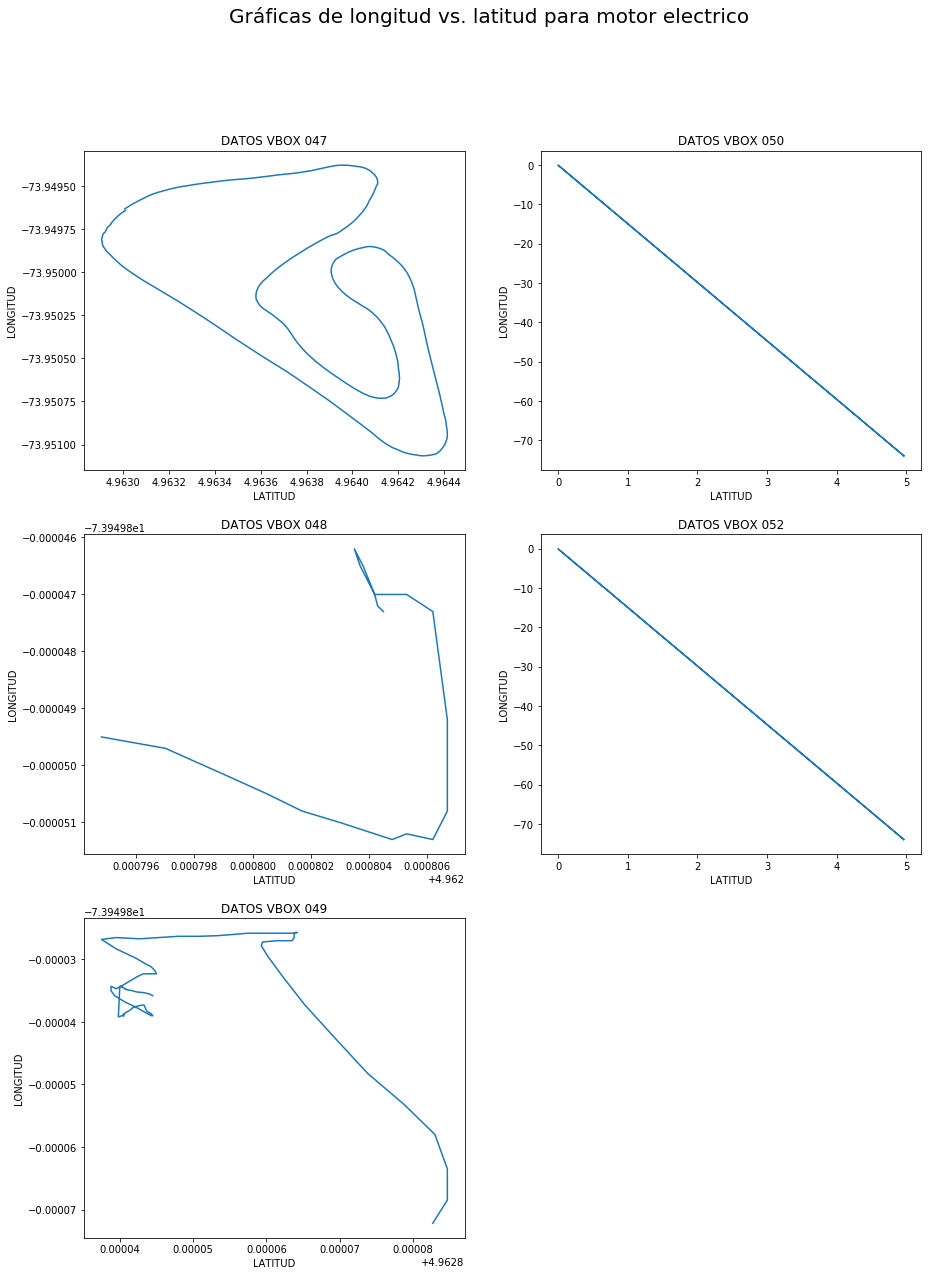

In [15]:
plt.figure(figsize=(15,20))
plt.suptitle('Gráficas de longitud vs. latitud para motor electrico', fontsize=20)
plt.subplot(3,2,1)
plt.plot(data_elec_047['LATITUD'][350:1555],data_elec_047['LONGITUD'][350:1555])
plt.title("DATOS VBOX 047")
plt.xlabel("LATITUD")
plt.ylabel("LONGITUD")
plt.subplot(3,2,3)
plt.plot(data_elec_048['LATITUD'],data_elec_048['LONGITUD'])
plt.xlabel("LATITUD")
plt.ylabel("LONGITUD")
plt.title("DATOS VBOX 048")
plt.subplot(3,2,5)
plt.plot(data_elec_049['LATITUD'],data_elec_049['LONGITUD'])
plt.xlabel("LATITUD")
plt.ylabel("LONGITUD")
plt.title("DATOS VBOX 049")
plt.subplot(3,2,2)
plt.plot(data_elec_050['LATITUD'],data_elec_050['LONGITUD'])
plt.xlabel("LATITUD")
plt.ylabel("LONGITUD")
plt.title("DATOS VBOX 050")
plt.subplot(3,2,4)
plt.plot(data_elec_052['LATITUD'],data_elec_052['LONGITUD'])
plt.xlabel("LATITUD")
plt.ylabel("LONGITUD")
plt.title("DATOS VBOX 052")
plt.show()

Los resultados obtenidos muestran claramente que el único archivo que contiene una vuelta completa del kart es el de VBOX 047, ya que los demás datos no demuestran el recorrido en pista del kart, se puede decir que los demás datos tomados fueron tomados por accidente. En este caso, no se graficó el archivo VBOX 051 debido a que en este solo hay una línea de datos leída.

In [16]:
Tiempo_vuelta_elec=data_elec_047['TIEMPO'][1555]-data_elec_047['TIEMPO'][350]
Tiempo_vuelta_elec

60.25

El tiempo de vuelta en el caso del carro electrico es de 60.25 s

### Kart combustión interna

Para el kart de combustión interna se hizo lo mismo del kart eléctrico, en este caso había varios archivos en los que se identifica que el kart daba más de una vuelta a la pista, para cada uno de ellos se calculó el tiempo de vuelta para tener el mejor.

Gráfica de pista recorrida por el kart de combustión interna

In [17]:
data_com_0024 = vbox_data('VBOX0024.VBO')

Text(0,0.5,'LONGITUD')

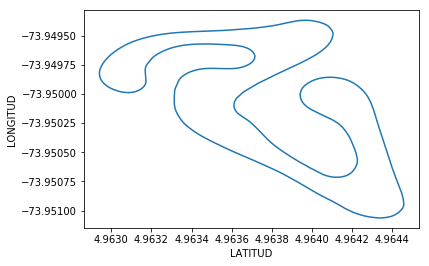

In [18]:
plt.plot(data_com_0024['LATITUD'][7600:13589],data_com_0024['LONGITUD'][7600:13589])
plt.xlabel("LATITUD")
plt.ylabel("LONGITUD")

Ya que en el archivo de cordoba ya se habian fijado las posiciones en el vector tiempo en el cual se daba una vuelta en el kart se tomaron estos tiempos para el archivo VBOX 0019, pero se calcularon de forma manual para los otros archivos.

In [19]:
data_com_0020 = vbox_data('VBOX0020.VBO')
data_com_0019 = vbox_data('VBOX0019.VBO')

In [20]:
Tiempo_1=(data_com_0019['TIEMPO'][15690]-data_com_0019['TIEMPO'][15690+5571])*-1
Tiempo_2=(data_com_0019['TIEMPO'][21260]-data_com_0019['TIEMPO'][21260+5565])*-1
Tiempo_3=(data_com_0019['TIEMPO'][26770]-data_com_0019['TIEMPO'][26770+5490])*-1
Tiempo_4=(data_com_0019['TIEMPO'][32260]-data_com_0019['TIEMPO'][32260+5490])*-1
Tiempo_5=(data_com_0019['TIEMPO'][37750]-data_com_0019['TIEMPO'][37750+5470])*-1

Tiempo_6=(data_com_0020['TIEMPO'][0]-data_com_0020['TIEMPO'][5475])*-1
Tiempo_7=(data_com_0020['TIEMPO'][5475]-data_com_0020['TIEMPO'][10880])*-1

Tiempo_8=(data_com_0024['TIEMPO'][7600]-data_com_0020['TIEMPO'][13589])*-1

In [21]:
Tiempos_combustion=np.array([Tiempo_1,Tiempo_2,Tiempo_3,Tiempo_4,Tiempo_5,Tiempo_6,Tiempo_7,Tiempo_8])
Tiempos_combustion_1=np.array(["Vuelta 1","Vuelta 2","Vuelta 3","Vuelta 4","Vuelta 5","Vuelta 1","Vuelta 2","Vuelta 1"])
Tiempos_combustion_2=np.array(["VBOX0019","VBOX0019","VBOX0019","VBOX0019","VBOX0019","VBOX0020","VBOX0020","VBOX0024"])
Tiempos_tabla = pd.DataFrame(columns=["ARCHIVO","VUELTA","TIEMPO VUELTA [S]"])
Tiempos_tabla['ARCHIVO']=Tiempos_combustion_2
Tiempos_tabla['TIEMPO VUELTA [S]']=Tiempos_combustion
Tiempos_tabla['VUELTA']=Tiempos_combustion_1
Tiempos_tabla

,ARCHIVO,VUELTA,TIEMPO VUELTA [S]
0,VBOX0019,Vuelta 1,55.71
1,VBOX0019,Vuelta 2,55.65
2,VBOX0019,Vuelta 3,54.90
3,VBOX0019,Vuelta 4,54.90
4,VBOX0019,Vuelta 5,54.70
5,VBOX0020,Vuelta 1,54.75
6,VBOX0020,Vuelta 2,54.05
7,VBOX0024,Vuelta 1,59.89


En la tabla se presentan los resultados obtenidos de los tiempos de vuelta del kart en combustión interna, el mínimo tiempo es de 54.05 segundos y el máximo de 59.89 segundos.

Comparando el tiempo de los dos tipos de motor observamos que el tiempo del kart de combustión es más rápido por casi más de 6 segundos, debemos tener en cuenta que la pista utilizada para el kart de combustión es más larga por lo que la diferencia entre tiempos es más grande en realidad.

### Velocidad instantánea
Para comparar la velocidad instantánea, se compararon la velocidad del kart eléctrico cuando dio la vuelta completa a la pista con las velocidades de los 3 mejores tiempos del kart de combustión
### Kart eléctrico


Text(0,0.5,'velocidad (m/s)')

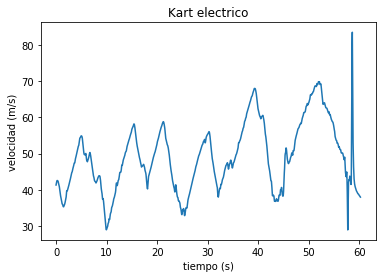

In [22]:
plt.plot(data_elec_047['TIEMPO'][350:1555]-data_elec_047['TIEMPO'][350],data_elec_047['VELOCIDAD'][350:1555])
plt.title("Kart electrico")
plt.xlabel("tiempo (s)")
plt.ylabel ("velocidad (m/s)")

In [68]:
max(data_elec_047['VELOCIDAD'][350:1555])

83.530000000000001

### Kart combustión interna

Text(0,0.5,'velocidad (m/s)')

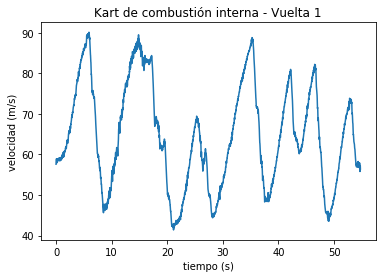

In [23]:
plt.plot(data_com_0020['TIEMPO'][0:5475]-data_com_0020['TIEMPO'][0],data_com_0020['VELOCIDAD'][0:5475])
plt.title("Kart de combustión interna - Vuelta 1")
plt.xlabel("tiempo (s)")
plt.ylabel ("velocidad (m/s)")

In [69]:
max(data_com_0020['VELOCIDAD'][0:5475])

90.111999999999995

Text(0,0.5,'velocidad (m/s)')

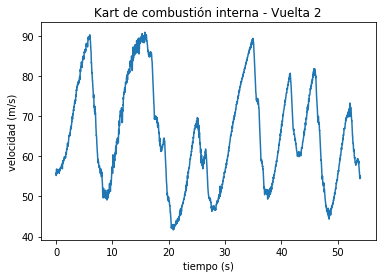

In [24]:
plt.plot(data_com_0020['TIEMPO'][5475:10880]-data_com_0020['TIEMPO'][5475],data_com_0020['VELOCIDAD'][5475:10880])
plt.title("Kart de combustión interna - Vuelta 2")
plt.xlabel("tiempo (s)")
plt.ylabel ("velocidad (m/s)")

In [70]:
max(data_com_0020['VELOCIDAD'][5475:10880])

90.966999999999999

Text(0,0.5,'velocidad (m/s)')

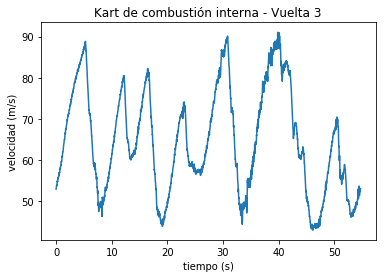

In [25]:
plt.plot(data_com_0019['TIEMPO'][37750:37750+5470]-data_com_0019['TIEMPO'][37750],data_com_0019['VELOCIDAD'][37750:37750+5470])
plt.title("Kart de combustión interna - Vuelta 3")
plt.xlabel("tiempo (s)")
plt.ylabel ("velocidad (m/s)")

In [71]:
max(data_com_0019['VELOCIDAD'][37750:37750+5470])

91.055999999999997

comparando las velocidades instantáneas del kart eléctrico y el kart de combustión interna en sus mejores vueltas, vemos que las velocidades del kart de combustión son más altas, en general. Por otro lado, la velocidad máxima alcanzada por el kart eléctrico fue de 83.53 m/s, mientras que, en el kart de combustión se alcanzaron velocidades de hasta 91.06 m/s en la vuelta más rápida.

### Aceleración
Para comparar la acelaeración, se comparo la acelareación del kart electrico cuando dio la vuelta completa a la pista con las aceleraciones de los 3 mejores tiempos del kart de combustión
### Kart electrico

Text(0,0.5,'aceleracion (m/s^2)')

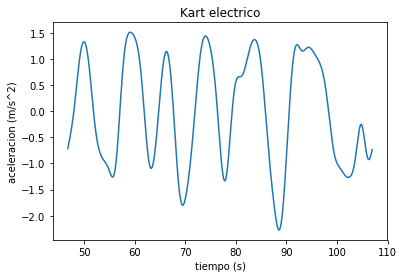

In [26]:
VELOCIDAD_MS_47 = data_elec_047['VELOCIDAD']/3.6
ACX_47 = accel(VELOCIDAD_MS_47[350:1555],(data_elec_047['dT'][350:1555]))
plot(data_elec_047['TIEMPO'][350:1555],ACX_47)
title("Kart electrico")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

### Kart combustión interna

Text(0,0.5,'aceleracion (m/s^2)')

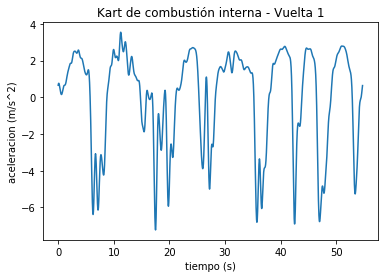

In [27]:
VELOCIDAD_MS_20_1 = data_com_0020['VELOCIDAD']/3.6
ACX_20_1 = accel(VELOCIDAD_MS_20_1[0:5475], data_com_0020['dT'][0:5475])
plot(data_com_0020['TIEMPO'][0:5475],ACX_20_1)
title("Kart de combustión interna - Vuelta 1")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

Text(0,0.5,'aceleracion (m/s^2)')

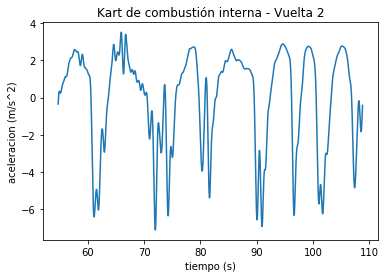

In [28]:
VELOCIDAD_MS_20_2 = data_com_0020['VELOCIDAD']/3.6
ACX_20_2 = accel(VELOCIDAD_MS_20_1[5475:10880], data_com_0020['dT'][5475:10880])
plot(data_com_0020['TIEMPO'][5475:10880],ACX_20_2)
title("Kart de combustión interna - Vuelta 2")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

Text(0,0.5,'aceleracion (m/s^2)')

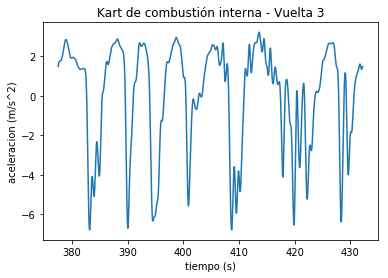

In [29]:
VELOCIDAD_MS_19 = data_com_0019['VELOCIDAD']/3.6
ACX_19 = accel(VELOCIDAD_MS_19[37750:37750+5470], data_com_0019['dT'][37750:37750+5470])
plot(data_com_0019['TIEMPO'][37750:37750+5470],ACX_19)
title("Kart de combustión interna - Vuelta 3")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

Comparando la aceleración del kart eléctrico y el de combustión, podemos observar que las aceleraciones y desaceleraciones son más altas, mientras que el motor eléctrico no permite llegar a estas aceleraciones.

## - Análisis del desempeño de los motores de combustión interna y eléctrico

### Momento par
### Kart eléctrico

Text(0,0.5,'torque (Nm)')

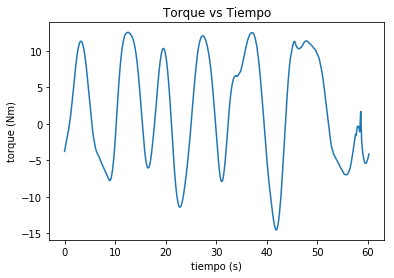

In [33]:
torque_47_1=torque_final(ACX_47,data_elec_047['VELOCIDAD'][350:1555],VELOCIDAD_MS_47[350:1555])
plot(data_elec_047['TIEMPO'][350:1555]-data_elec_047['TIEMPO'][350],torque_47_1)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")

### Kart combustión interna

Text(0,0.5,'torque (Nm)')

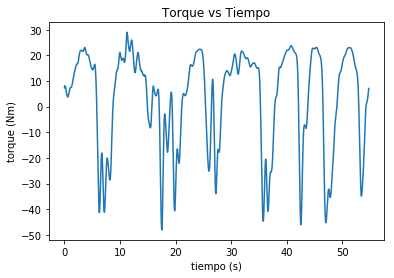

In [34]:
torque_20_1=torque_final(ACX_20_1,data_com_0020['VELOCIDAD'][0:5475],VELOCIDAD_MS_20_1[0:5475])
plot(data_com_0020['TIEMPO'][0:5475]-data_com_0020['TIEMPO'][0],torque_20_1)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")

Text(0,0.5,'torque (Nm)')

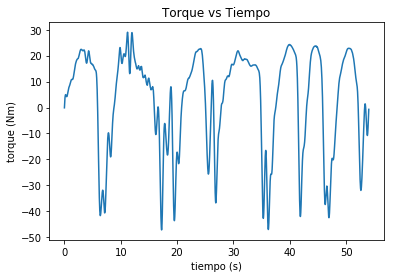

In [35]:
torque_20_2=torque_final(ACX_20_2,data_com_0020['VELOCIDAD'][5475:10880],VELOCIDAD_MS_20_1[5475:10880])
plot(data_com_0020['TIEMPO'][5475:10880]-data_com_0020['TIEMPO'][5475],torque_20_2)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")

Text(0,0.5,'torque (Nm)')

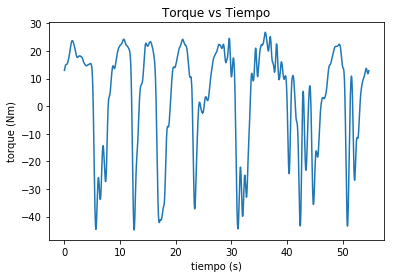

In [36]:
torque_19=torque_final(ACX_19,data_com_0019['VELOCIDAD'][37750:37750+5470],VELOCIDAD_MS_19[37750:37750+5470])
plot(data_com_0019['TIEMPO'][37750:37750+5470]-data_com_0019['TIEMPO'][37750],torque_19)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")


### Velocidad de giro
### Kart eléctrico

Text(0,0.5,'velocidad (RPM)')

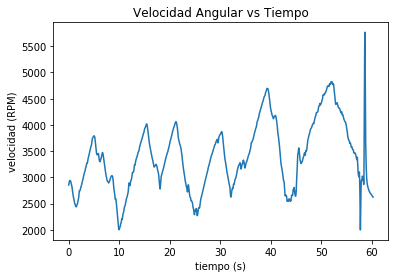

In [37]:
omegam_47 = vangularmotor(VELOCIDAD_MS_47[350:1555])
plot(data_elec_047['TIEMPO'][350:1555]-data_elec_047['TIEMPO'][350],omegam_47*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (RPM)")

### Kart combustión interna

Text(0,0.5,'velocidad (RPM)')

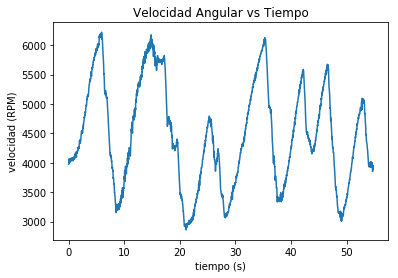

In [38]:
omegam_20_1 = vangularmotor(VELOCIDAD_MS_20_1[0:5475])
plot(data_com_0020['TIEMPO'][0:5475]-data_com_0020['TIEMPO'][0],omegam_20_1*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (RPM)")

Text(0,0.5,'velocidad (RPM)')

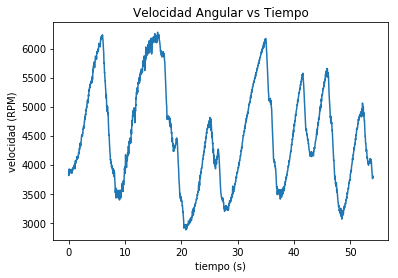

In [39]:
omegam_20_2 = vangularmotor(VELOCIDAD_MS_20_2[5475:10880])
plot(data_com_0020['TIEMPO'][5475:10880]-data_com_0020['TIEMPO'][5475],omegam_20_2*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (RPM)")

Text(0,0.5,'velocidad (RPM)')

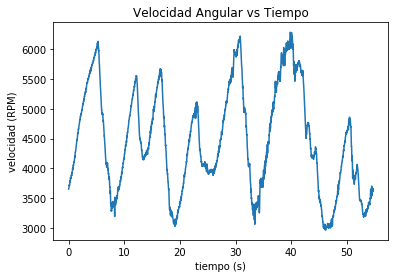

In [40]:
omegam_19 = vangularmotor(VELOCIDAD_MS_19[37750:37750+5470])
plot(data_com_0019['TIEMPO'][37750:37750+5470]-data_com_0019['TIEMPO'][37750],omegam_19*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (RPM)")

### Potencia
### Kart eléctrico

Text(0,0.5,'potencia (kW)')

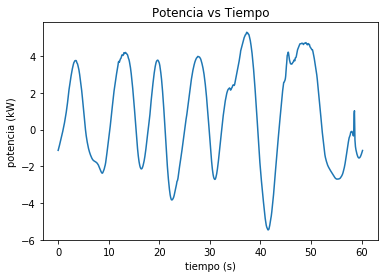

In [47]:
plot(data_elec_047['TIEMPO'][350:1555]-data_elec_047['TIEMPO'][350],omegam_47*torque_47_1/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")

In [72]:
max(omegam_47*torque_47_1/1000)

5.2866790418467495

### Kart combustión interna

Text(0,0.5,'potencia (kW)')

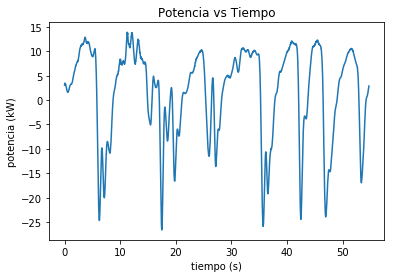

In [43]:
plot(data_com_0020['TIEMPO'][0:5475]-data_com_0020['TIEMPO'][0],omegam_20_1*torque_20_1/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")

In [73]:
max(omegam_20_1*torque_20_1/1000)

13.901931104446387

Text(0,0.5,'potencia (kW)')

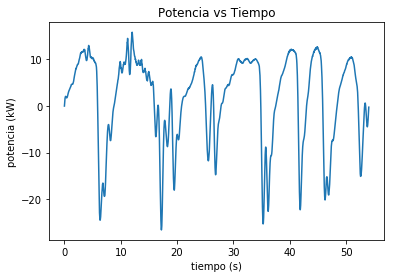

In [44]:
plot(data_com_0020['TIEMPO'][5475:10880]-data_com_0020['TIEMPO'][5475],omegam_20_2*torque_20_2/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")


In [74]:
max(omegam_20_2*torque_20_2/1000)

15.742175498952374

Text(0,0.5,'potencia (kW)')

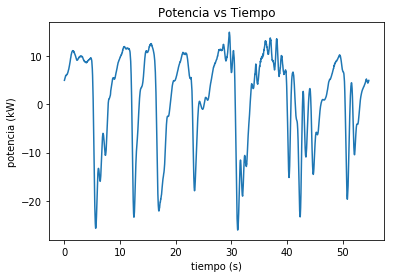

In [45]:
plot(data_com_0019['TIEMPO'][37750:37750+5470]-data_com_0019['TIEMPO'][37750],omegam_19*torque_19/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")

In [75]:
max(omegam_19*torque_19/1000)

14.933698050148575

Con respecto al desempeño de los motores de combustión y el eléctrico podemos observar que el motor de combustión interna es capaz de entregar más momento par, tiene velocidad de giro mayor y por esta razón la potencia entregada es más alta en el motor de combustión. Más específicamente, el motor eléctrico entrega máximo una potencia de 5.3 kW, mientras que el motor de combustión entrega hasta 15.7 kW.

## Conclusiones respecto al rendimiento de los vehículos y motores

En base a los resultados obtenidos podemos concluir:

- El rendimiento del vehículo de combustión interna es más alto que el eléctrico, con respecto al tiempo de vuelta, velocidades instantáneas y aceleración.

- El desempeño del motor de combustión es mejor que el eléctrico, ya que es capaz de entregar momentos par más altos y su velocidad de giro es mayor, lo que conlleva a tener una mejor entrega de potencia, más específicamente, la potencia entregada por el motor de combustión puede ser hasta 3 veces que la entrega el motor eléctrico.

## Posibles mejoras al kart eléctrico para acercar su desempeño al del kart con motor de combustión interna.

De acuerdo al análisis y a los resultados obtenidos se sugieren posibles mejoras al kart eléctrico para mejorar su desempeño:

- Con respecto a la estructura del vehículo se sugiere hacerlo más liviano y de esta manera se lograría mejorar el desempeño del kart. De igual manera, se podría pensar en hacerlo de alguna manea más aerodinámico lo que ayudaría a la entrega de potencia del motor.

- Por otro lado, la otra opción es hacer modificaciones al motor eléctrico para así mejorar el desempeño, sin embargo, hacerle mejoras a un motor eléctrico es complicado debido a que existen muchas restricciones en el sistema eléctrico del mismo. Por ejemplo, aumentar la potencia de salida de las baterías llevaría a un aumento de temperatura que afectaría la vida útil de otros componentes del motor. Así que una mejora en el motor no es una opción muy viable, por lo que si se quiere mejorar el motor se recomendaría buscar un motor eléctrico que sea capaz de entregar más potencia.

